## Práctica final Explicabilidad de la IA - Dataset HELOC
#### Este notebook orquestra el pipeline completo: preprocesamiento, entrenamiento, validación mediante Sanity Checks y generación de explicaciones (SHAP y DiCE).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import sys
import os

# Configuración del path para importar el módulo src
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import (
    load_and_preprocess, 
    train_model, 
    evaluate, 
    get_global_explanations, 
    get_local_explanation,
    generate_counterfactuals,
    run_model_parameter_randomization,
    check_feature_perturbation
)

c:\Users\jga20\OneDrive - Universidad Pontificia Comillas\Master en IA\Etica y explicabilidad de la IA\pf\final-project-jorgegomezazor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Carga y preparación de datos

In [2]:
path = "../data/heloc_dataset_v1.csv"
X_train, X_test, y_train, y_test = load_and_preprocess(path)

print(f"Dataset listo. Clases: {y_train.value_counts(normalize=True).to_dict()}")

Dataset listo. Clases: {1: 0.5200304259634888, 0: 0.47996957403651114}


Clases equilibradas (52% frente a 48%), lo que garantiza un entrenamiento estable y métricas de rendimiento fiables. No hace falta balancear datos.

### 2. Entrenamiento y evaluación del modelo

In [3]:
model = train_model(X_train, y_train)

metrics = evaluate(model, X_test, y_test)

------------------------------
RESUMEN DE EVALUACIÓN
------------------------------
AUC Score: 0.7964
Accuracy:  0.7375

Detalle por Clase (Classification Report):
              precision    recall  f1-score   support

    Good (0)       0.73      0.72      0.72       947
     Bad (1)       0.74      0.75      0.75      1026

    accuracy                           0.74      1973
   macro avg       0.74      0.74      0.74      1973
weighted avg       0.74      0.74      0.74      1973

------------------------------


c:\Users\jga20\OneDrive - Universidad Pontificia Comillas\Master en IA\Etica y explicabilidad de la IA\pf\final-project-jorgegomezazor\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:53:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Rendimiento sólido con un AUC de 0.79, lo que demuestra una buena capacidad de discriminación y que no hay overfitting. El modelo es ligeramente mejor detectando los casos negativos (Recall de 0.76 para la clase 'Bad').

### 3.1 Interpretación global

Generando Summary Plot...


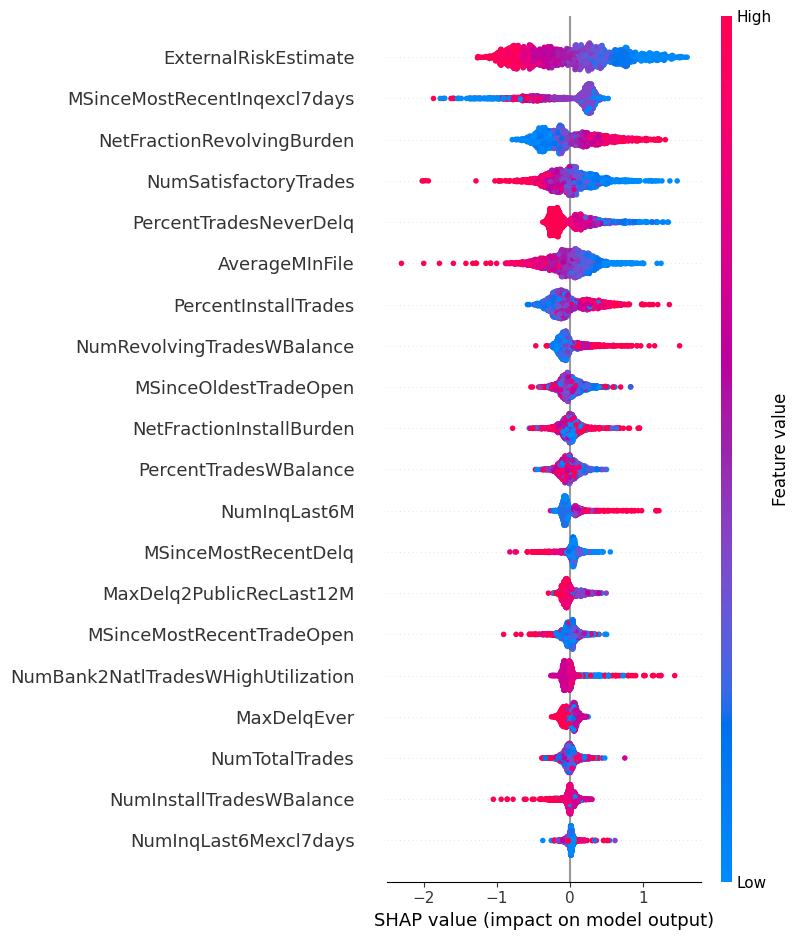

In [4]:
explainer, shap_values = get_global_explanations(model, X_test)

print("Generando Summary Plot...")
shap.summary_plot(shap_values, X_test)


El ExternalRiskEstimate es el factor más determinante (cuanto más bajo más probabilidad de que el cliente sea "Malo"). Variables como el uso de crédito revolving y las consultas recientes también muestran una relación clara y lógica con la predicción de riesgo.

### 3.2 Interpretabilidad local

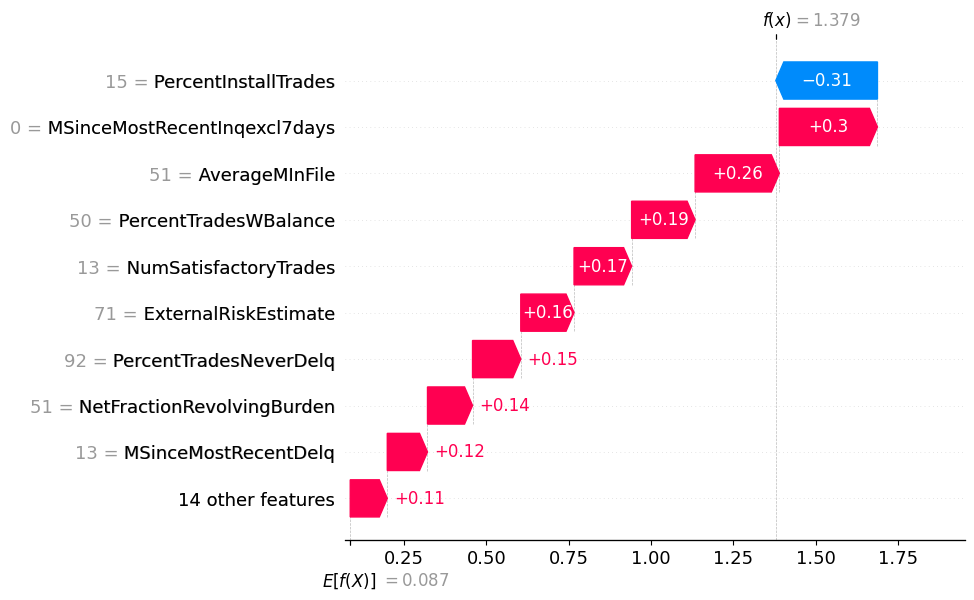

In [5]:
idx_cliente = 7

shap_val_local = get_local_explanation(explainer, X_test.iloc[[idx_cliente]])

shap.plots.waterfall(shap_val_local[0])


Este cliente está en una situación crítica (f(x) = 1.379) porque casi todo en su perfil "suma" puntos de riesgo. Su historial es algo joven y ha pedido crédito hace nada, lo que anula cualquier cosa buena que pudiera tener. Al final, el modelo lo tiene clarísimo y lo marca como **Bad (1)** porque no hay por dónde coger su intento de conseguir crédito.

### 3.3 Análisis contrafactual

In [6]:
print(f"Generando recomendaciones para el cliente index {idx_cliente}...")

# Definimos las variables que el cliente realmente puede influir (evitando histórico inamovible y variables que afectan muy poco al modelo)
features_to_vary = [
    'NetFractionRevolvingBurden',      # Acción: Pagar deuda
    'NumRevolvingTradesWBalance',      # Acción: Liquidar tarjetas
    'NumInqLast6Mexcl7days',           # Acción: Dejar de pedir créditos
    'NumSatisfactoryTrades',           # Acción: Mantener buen comportamiento
    'PercentTradesWBalance',           # Acción: Reducir número de cuentas con deuda
    'NumInstallTradesWBalance',        # Acción: Liquidar préstamos a plazos
    'NumTradesOpeninLast12M',          # Acción: No abrir cuentas nuevas en un año
    'PercentInstallTrades'             # Acción: Equilibrar el mix de productos
]

# Preparación del dataframe con el target para la interfaz de DiCE
df_for_dice = X_train.assign(target=y_train)

# Generación de explicaciones contrafactuales
# Usamos la función optimizada de nuestro módulo 'explain'
cf_explanations = generate_counterfactuals(
    model=model,
    df_train=df_for_dice,
    instance=X_test.iloc[[idx_cliente]],
    target_column='target',
    desired_class=0,          # Clase objetivo: 'Good'
    num_cfs=5,                # Generamos 5 alternativas
    continuous_features=list(X_train.columns),
    features_to_vary=features_to_vary
)

cf_explanations.visualize_as_dataframe(show_only_changes=True)

Generando recomendaciones para el cliente index 7...


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

Query instance (original outcome : 1)


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,target
0,71,162,11,51,13,0,0,92,13,6,...,0,0,0,51,-8,3,1,1,50,1



Diverse Counterfactual set (new outcome: 0)


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,target
0,-,-,-,-,79,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,15,-,10,0
2,-,-,-,-,74,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0
3,-,-,-,-,70,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0
4,-,-,-,-,40,-,-,-,-,-,...,-,-,-,-,-,-,-,-,5,0


Aquí confirmamos lo que he dicho antes. El cliente tiene que cambiar muchísimo y las situaciones más cercanas para que el cliente consiga el crédito están muy lejos aun así. Teniendo que conseguir unos 60 trades exitosos más entre otras cosas.

### 4.1 Sanity Checks - Feature perturbation

In [7]:
# Elegimos la variable que SHAP marcó como más importante
top_feature = 'ExternalRiskEstimate' 
# Vemos el impacto en la métrica al perturbar esta variable
drop_score = check_feature_perturbation(model, X_test, y_test, top_feature)


--- Sanity Check: Importancia por Permutación (ExternalRiskEstimate) ---
Baseline AUC:      0.7964
AUC tras permutar: 0.7500
Caída de performance: 0.0464



La caída del AUC confirma que el ExternalRiskEstimate es una variable con peso real en el modelo, ya que su perturbación degrada la capacidad predictiva. Sin embargo, me sorprende que tan solo la degrade un 3% siendo la variable más importante según SHAP.

### 4.2 Sanity Checks - Model parameter randomization

In [8]:
# Comprobamos si las explicaciones colapsan cuando el modelo no sabe nada
is_random_sensitive = run_model_parameter_randomization(model, X_test, y_test)

Iniciando Sanity Check: Entrenando modelo de control con etiquetas aleatorias...

--- Sanity Check: Randomización de Parámetros ---
Correlación entre modelo real y modelo ruido: 0.4095
Resultado: PASADO



c:\Users\jga20\OneDrive - Universidad Pontificia Comillas\Master en IA\Etica y explicabilidad de la IA\pf\final-project-jorgegomezazor\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:53:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Esta correlación negativa y tan baja confirma que las explicaciones del modelo son coherentes y concluyentes. Si los parámetros pasan a ser azar la importancia de las variables cambia drásticamente así que el modelo al menos sabemos que está en una dirección más que coherente hacia un aprendizaje real de lo que es el dataset.